In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import glob
import random

### Load images -  get paths & images/arrays

#### Class

In [2]:

class Images():
    def __init__(self, folder):
        self.folder = folder
        self.data = '../raw_data'
        

    def get_images_from_folder(self):
        for root, dirs, files in os.walk(self.data):
            for d in dirs:
                if d == self.folder:
                    directory = os.path.join(root, d, 'img')
        files = os.listdir(directory)
        
        return [file for file in files]
    

    def get_images_as_arrays(self):
        for root, dirs, files in os.walk(self.data):
            for d in dirs:
                if d == self.folder:
                    directory = os.path.join(root, d, 'img')
        files = os.listdir(directory)
        images = []
        for f in files:
            dir_path = os.path.join(self.data, self.folder, 'img', f)
            absolute_path = os.path.abspath(dir_path)
            image_file = glob.glob(os.path.join(absolute_path))
            image = plt.imread("".join(image_file))
            images.append(image)
            
        return np.array(images)
    
    
    def display_image(self, nr=2):
        folder = self.folder.capitalize()
        img_list = self.get_images_from_folder()
        random_images = random.sample(img_list, k=min(nr, len(img_list)))

        num_rows = (len(random_images) + 1) // 2
        num_cols = min(2, len(random_images))

        if num_rows == 0 or num_cols == 0:
            return  # No images to display

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows))

        if num_rows == 1:
            axes = np.array([axes])  # Convert to NumPy array
            axes = axes.reshape(1, num_cols)

        for i, r in enumerate(random_images):
            dir_path = "../raw_data/" + folder + "/img/"
            absolute_path = os.path.abspath(dir_path)
            image_file = glob.glob(os.path.join(absolute_path, r))
            image = plt.imread("".join(image_file))

            ax = axes[i // num_cols, i % num_cols]
            ax.imshow(image)
            ax.axis("off")

        plt.tight_layout()
        plt.show()
    

#### Create objects and visualize images

In [3]:
falciparum = Images('Falciparum')
malariae = Images('Malariae') 
ovale = Images('Ovale' ) 
vivax = Images('Vivax') 

In [4]:
print(f'falciparum: {len(falciparum.get_images_from_folder())} \
      malariae: {len(malariae.get_images_from_folder())} \
      ovale: {len(ovale.get_images_from_folder())} \
      vivax: {len(vivax.get_images_from_folder())}'
      )

falciparum: 104       malariae: 37       ovale: 29       vivax: 40


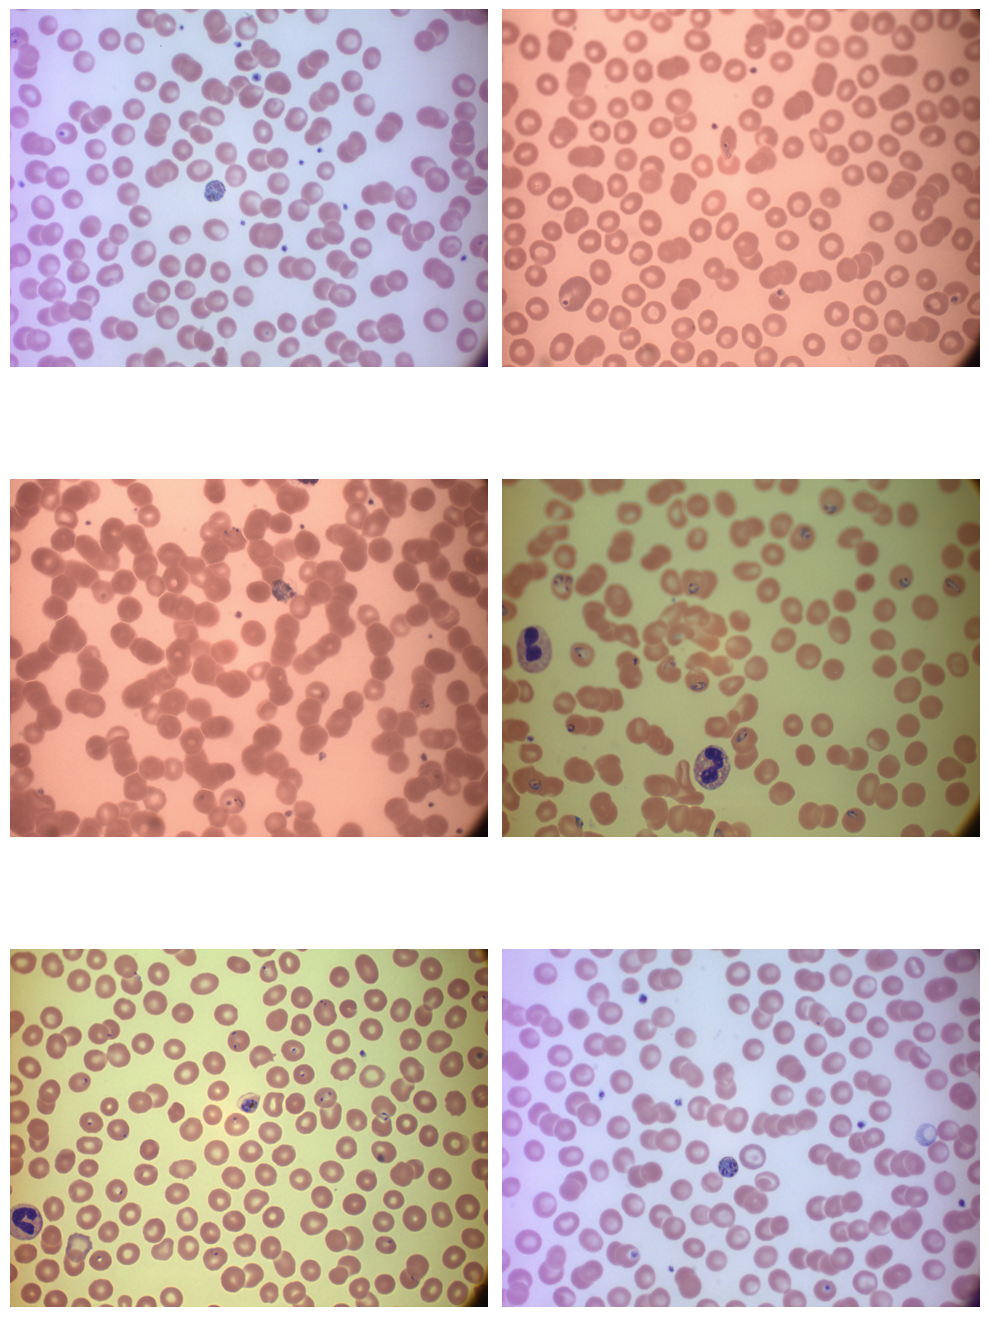

In [5]:
falciparum.display_image(6)

### Species Categories

In [6]:
def get_letter_combinations(text):
    if '0021_R_T' in text:
        text_group = 'R_T'
    else:
        last_dash = text.rfind('-')
        last_dot = text.rfind('.')
        text_group = text[last_dash +1 : last_dot]
    
    return text_group  

In [7]:
def create_df():

    combo = [falciparum.get_images_from_folder(), 
             malariae.get_images_from_folder(), 
             ovale.get_images_from_folder(),
             vivax.get_images_from_folder() ]
    
    dfs = []
    for species in combo:
        counts = {}
        for t in species:
            letter = get_letter_combinations(t)

            if letter in counts:
                counts[letter] += 1
            else:
                counts[letter] = 1
        dfs.append(counts)

    keys = ['falciparum', 'malariae', 'ovale', 'vivax']
    df = pd.DataFrame.from_records(dfs, index=keys) #df from list of dicts
    df = df.replace([np.inf, -np.inf, np.nan], 0) #replace inf and nan with 0
    df = df.astype(int) #convert to int
    df = df.transpose() 
    return df

df=create_df()
df

,falciparum,malariae,ovale,vivax
T,8,19,9,3
S,10,9,1,9
R,68,0,8,19
R_T,12,1,2,2
R_S,3,0,0,0
R_T_S,1,0,0,0
T_R,1,0,1,0
S_R,1,0,0,1
G,0,7,6,3
S_T,0,1,0,0


### Plotting

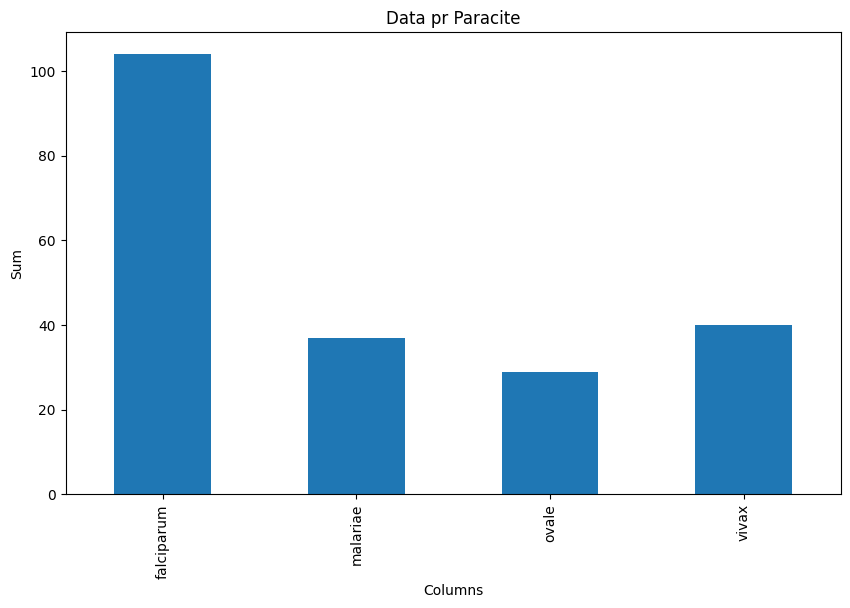

In [159]:
sums = df.sum()
sums.plot(kind='bar', figsize=(10, 6))
plt.title('Data pr Paracite')
plt.xlabel('Columns')
plt.ylabel('Sum')
plt.show()

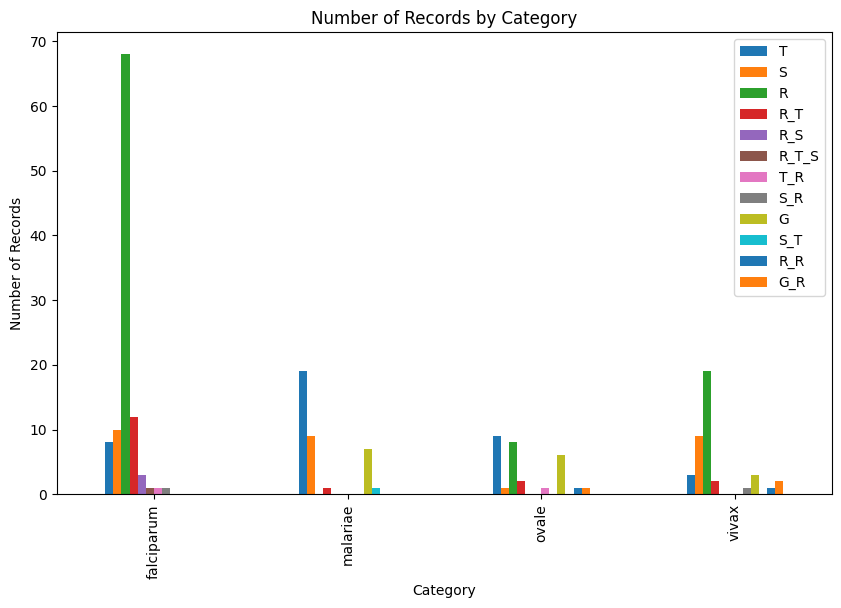

In [156]:
df.T.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Records by Category')
plt.xlabel('Category')
plt.ylabel('Number of Records')
plt.show()

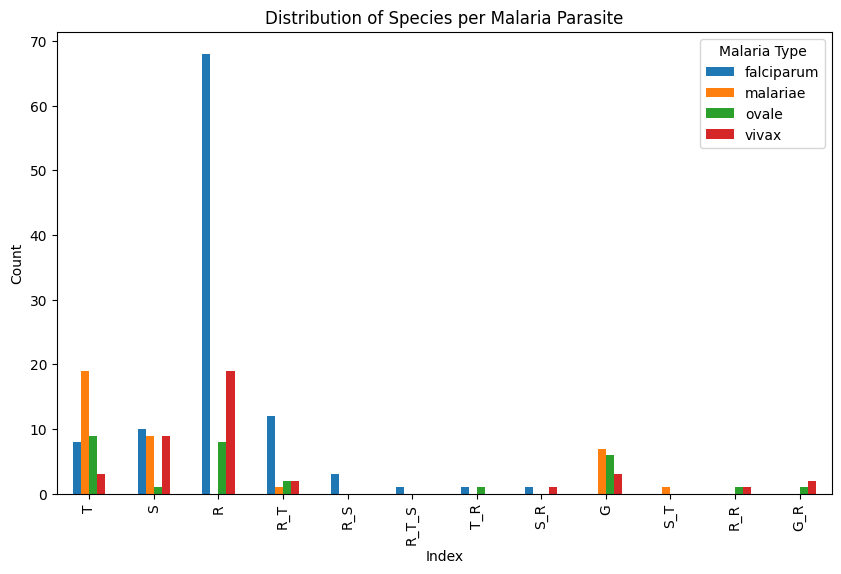

In [8]:
df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Distribution of Species per Malaria Parasite')
plt.legend(title='Malaria Type')
plt.show()

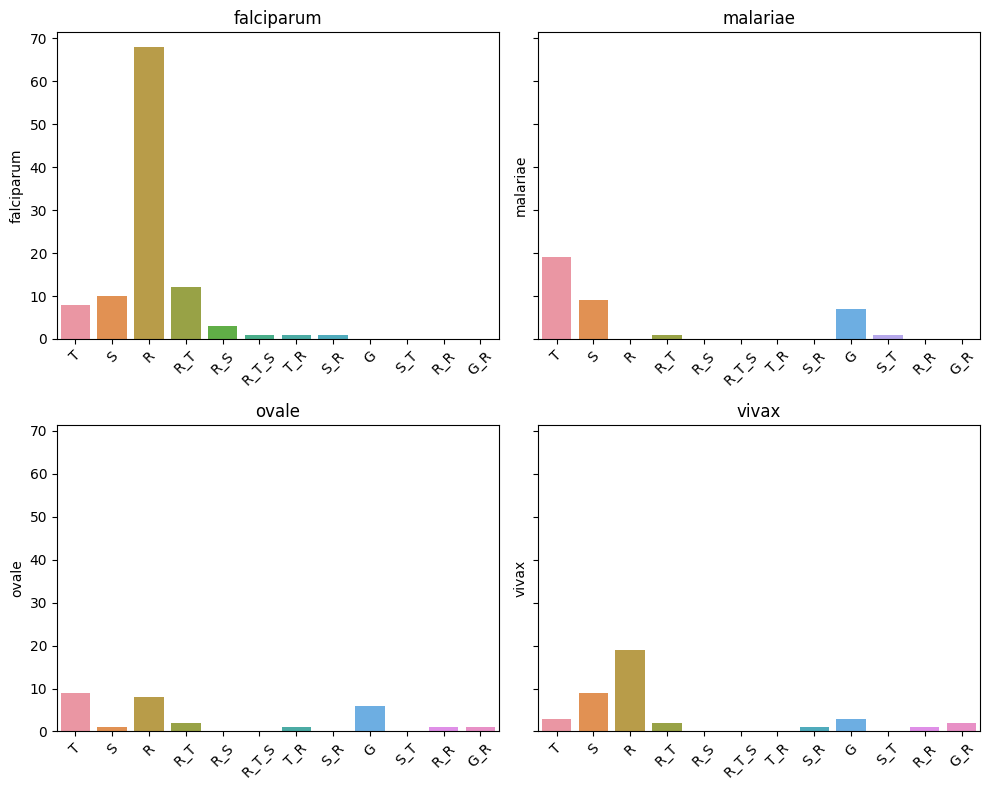

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for i, col in enumerate(['falciparum', 'malariae', 'ovale', 'vivax']):
    sns.barplot(data=df, x=df.index, y=col, ax=axes[i])

    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Simple MultiClass Model


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Flatten, MaxPooling2D

fal = falciparum.get_images_as_arrays()
mal = malariae.get_images_as_arrays()
ova = ovale.get_images_as_arrays()
viv = vivax.get_images_as_arrays()

In [18]:
X = np.concatenate((fal,mal,ova,viv), axis=0)
X.shape

(210, 1944, 2592, 3)

In [130]:
a= np.full((1,len(fal)), 1)
b= np.full((1,len(mal)), 2)
c= np.full((1,len(ova)), 3)
d= np.full((1,len(viv)), 4)

y = np.hstack((a,b,c,d))
y = y.reshape(210,1)

for value in y:
    value -= 1

In [77]:
from skimage.transform import resize
X_reshaped = np.zeros((210, 100, 100, 3), dtype=np.float32)

for i in range(X.shape[0]):
    X_reshaped[i] = resize(X[i], (100, 100, 3))

X_reshaped.shape

(210, 100, 100, 3)

In [136]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size =.3)
y_cat_train = to_categorical(y_train, num_classes=4)
y_cat_test = to_categorical(y_test, num_classes=4)

In [175]:
#Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['Accuracy'])

In [138]:
model.fit(X_train, y_cat_train, epochs=10, batch_size=32)

Epoch 1/10
5/5 [==============================] - 1s 121ms/step - loss: 313.7951 - recall: 0.1769
Epoch 2/10
5/5 [==============================] - 1s 121ms/step - loss: 17.4978 - recall: 0.2653
Epoch 3/10
5/5 [==============================] - 1s 116ms/step - loss: 2.8390 - recall: 0.3946
Epoch 4/10
5/5 [==============================] - 1s 122ms/step - loss: 2.5297 - recall: 0.3878
Epoch 5/10
5/5 [==============================] - 1s 120ms/step - loss: 2.9692 - recall: 0.4490
Epoch 6/10
5/5 [==============================] - 1s 119ms/step - loss: 2.4538 - recall: 0.4626
Epoch 7/10
5/5 [==============================] - 1s 116ms/step - loss: 1.7773 - recall: 0.4354
Epoch 8/10
5/5 [==============================] - 1s 121ms/step - loss: 2.7724 - recall: 0.4218
Epoch 9/10
5/5 [==============================] - 1s 122ms/step - loss: 1.6071 - recall: 0.4558
Epoch 10/10
5/5 [==============================] - 1s 119ms/step - loss: 1.1745 - recall: 0.5034


In [220]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    patience = 5,
    verbose = 1,
    restore_best_weights = True)

history = model.fit(X_train, 
                    y_cat_train, 
                    validation_split = 0.3,
                    epochs = 50,
                    callbacks=[es],
                    verbose = 1) 
#Evaluate
Result = model.evaluate(X_test, y_cat_test)
Result

Epoch 1/50
4/4 [==============================] - 1s 125ms/step - loss: 0.3156 - Accuracy: 0.8725 - val_loss: 0.3472 - val_Accuracy: 0.7778
Epoch 2/50
4/4 [==============================] - 0s 115ms/step - loss: 0.2883 - Accuracy: 0.8824 - val_loss: 0.4175 - val_Accuracy: 0.7333
Epoch 3/50
4/4 [==============================] - 0s 117ms/step - loss: 0.3863 - Accuracy: 0.8333 - val_loss: 0.5553 - val_Accuracy: 0.6000
Epoch 4/50
4/4 [==============================] - 0s 114ms/step - loss: 0.4719 - Accuracy: 0.8039 - val_loss: 0.3384 - val_Accuracy: 0.8889
Epoch 5/50
4/4 [==============================] - 0s 114ms/step - loss: 0.2570 - Accuracy: 0.8922 - val_loss: 0.4695 - val_Accuracy: 0.7556
Epoch 6/50
4/4 [==============================] - 0s 115ms/step - loss: 0.3283 - Accuracy: 0.8333 - val_loss: 0.3209 - val_Accuracy: 0.8667
Epoch 7/50
4/4 [==============================] - 0s 116ms/step - loss: 0.3012 - Accuracy: 0.8235 - val_loss: 0.2848 - val_Accuracy: 0.8667
Epoch 8/50
4/4 [====

[0.4354209303855896, 0.7777777910232544]

In [240]:
def plot_history(history):
    plt.figure(figsize=(9,6))
    train = history.history['Accuracy']
    validate = history.history['val_Accuracy']
    epochs = range(1, len(train) + 1)
    
    plt.plot(epochs, train, 'b', label='Train ')
    plt.plot(epochs, validate, 'r', label='Validation')
    plt.title('Train and Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

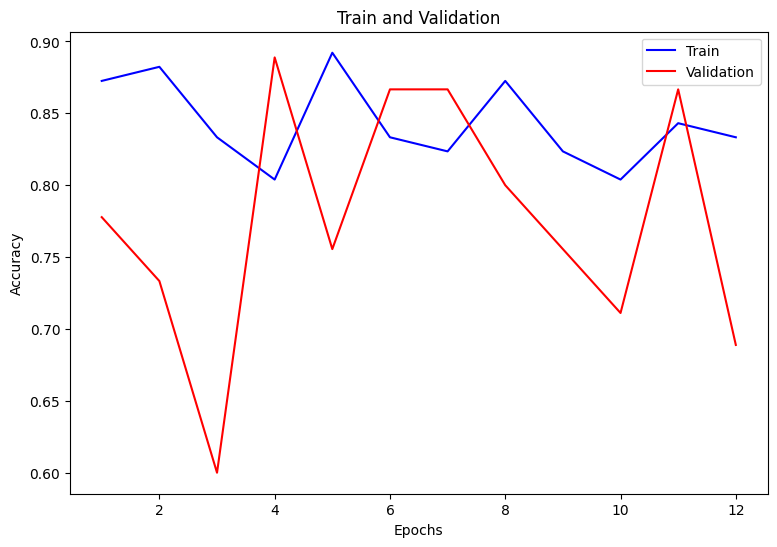

In [241]:
plot_history(history)

### Data Augmentation

In [296]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip = True,
    ) 

datagen.fit(X_train)

In [294]:
X_augmented_iterator = datagen.flow(X_train, shuffle=False, batch_size=1)
X_augmented_iterator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


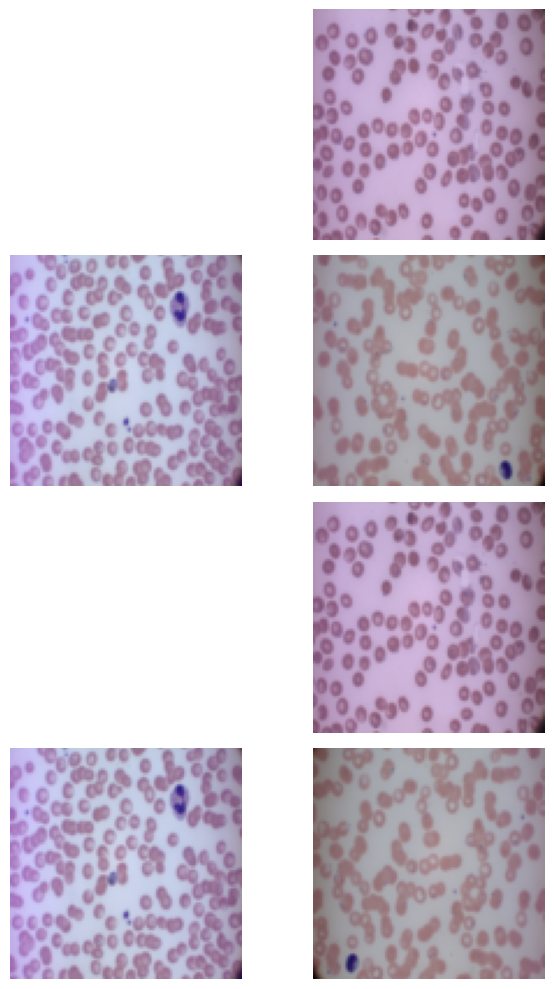

In [295]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(7, 10))

for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)):
    if i >= 4:
        break
    row = i // 2
    col = i % 2
    axes[row, col].imshow(raw_image)
    axes[row, col].axis('off')
    axes[row+2, col].imshow(augmented_image[0])  # Assuming augmented_image is a single image
    axes[row+2, col].axis('off')

plt.tight_layout()
plt.show()
